<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on MNIST dataset.

## Objectives
In this TP you will learn to : 
* Write multilayer perceptron and convolutional network with `Keras`and `Tensorflow`
* Understand how `convolutional`, `max pooling`, `stride` and `padding`layers work.
* Use these models for image classification.

## Libraries

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import pandas as pd
import numpy as np
import time

import tensorflow.keras.utils as ku
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.preprocessing.image as k


from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow
tensorflow.__version__

'2.4.1'

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4295586769388131367
]


2022-09-27 14:14:29.529548: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset 

The dataset that will be used in this TP is the [MNIST DataBase](http://yann.lecun.com/exdb/mnist/).<br>
It is composed of 70.000 images (60.000 for learning, 10.000 for test) of 28x28 pixels of handwritten digits from 0 to 9.<br>

These data are directly available on the `Keras` library.

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
N_train, N_x_pixels, N_y_pixels = X_train.shape
N_test = X_test.shape[0]
N_classes = len(set(Y_train))

print("Train data : %d images  (%d/%d pixels)" %(N_train, N_x_pixels, N_y_pixels))
print("Test data : %d images  (%d/%d pixels)" %(N_test, N_x_pixels, N_y_pixels))

11493376/11490434 [==============================] - 2s 0us/step
Train data : 60000 images  (28/28 pixels)
Test data : 10000 images  (28/28 pixels)


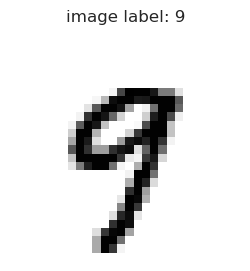

In [5]:
sample_index = 45
fig =plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
ax.set_title("image label: %d" % Y_train[sample_index])
ax.grid(False)
ax.axis('off')
plt.show()

### Image example

## Image classification with Multi Layer Perceptron model.

We will first try to learn an image classifier with a MLP model with the following architecture.

* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 128 neurons and *relu* activation function
* A Dropout Layer with 20% drop rate
* A Dense layer with 10 neurons (Number of classes ) and *softmax* activation function

### Data format

Some modifications are required on the data to use them with our model. 

The first layer is a Dense Layer, which handles 1D vectors as an input. We must first reshape the 2D 28x28 images as a 1D $28*28=784$ vector.

In [19]:
X_train_flatten = X_train.reshape((N_train, N_x_pixels*N_y_pixels))/255
X_test_flatten = X_test.reshape((N_test, N_x_pixels*N_y_pixels))/255
N_dim_flatten = X_train_flatten.shape[1]
print("Dimensions of flatten train images : %d X %d" %(X_train_flatten.shape))
print("Dimensions of flatten test images : %d X %d" %(X_test_flatten.shape))

Dimensions of flatten train images : 60000 X 784
Dimensions of flatten test images : 10000 X 784


### Architecture 

In [20]:
# Définition du réseau
model = km.Sequential()
model.add(kl.Dense(128, activation='relu', input_shape=(N_dim_flatten,)))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(128, activation='relu'))
model.add(kl.Dropout(0.2))
model.add(kl.Dense(N_classes, activation='softmax'))
# Réumé
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


**Q** The summary displays the number of pararameters/weigths of the model. Retrieve these values with the formulas seen in the course.

In [21]:
784*128+128+128*128+128+128*10+10

118282

### Training

You will now instantiate your model by defining :
* An optimizer : `RMSprop`
* a loss function : `Categorical crossentropy`
* Metric : This argument is an option, it allows to compute the metric if you want to check the evolution of the training. Here we choose to compute the accuracy during the training.

**Note** : In Keras you can choose either "sparse_categorical_crossentropy" or "categorical_crossentropy" loss. The former handles 1D (NX1) vectors where each entry contains the label of the data, i.e [0,3,5,9,3,4,...]. The latter handles only one-hot encoding of this vector, ie  2D vectors (NXN_classes) matrices. Keras has a `to_categorical` function which allows to convert a vector to its one-hot encoding representation.

In [22]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=ko.RMSprop(),
              metrics=['accuracy'])

In [23]:
batch_size = 256
epochs=10
ts = time.time()
history = model.fit(X_train_flatten, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_flatten, Y_test))
te = time.time()
t_train_mpl = te-ts

Epoch 1/10
235/235 [==============================] - 3s 13ms/step - loss: 0.7355 - accuracy: 0.7800 - val_loss: 0.1839 - val_accuracy: 0.9458
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: 0.2130 - accuracy: 0.9367 - val_loss: 0.1269 - val_accuracy: 0.9608
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1537 - accuracy: 0.9537 - val_loss: 0.1095 - val_accuracy: 0.9661
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.1250 - accuracy: 0.9619 - val_loss: 0.0923 - val_accuracy: 0.9723
Epoch 5/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1023 - accuracy: 0.9687 - val_loss: 0.0897 - val_accuracy: 0.9727
Epoch 6/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0948 - accuracy: 0.9714 - val_loss: 0.0890 - val_accuracy: 0.9736
Epoch 7/10
235/235 [==============================] - 3s 13ms/step - loss: 0.0825 - accuracy: 0.9746 - val_loss: 0.0836 - val_accuracy: 0.9751
E

### Results

Test loss: 0.08092144876718521
Test accuracy: 0.9782000184059143
Time Running: 24.66 seconds


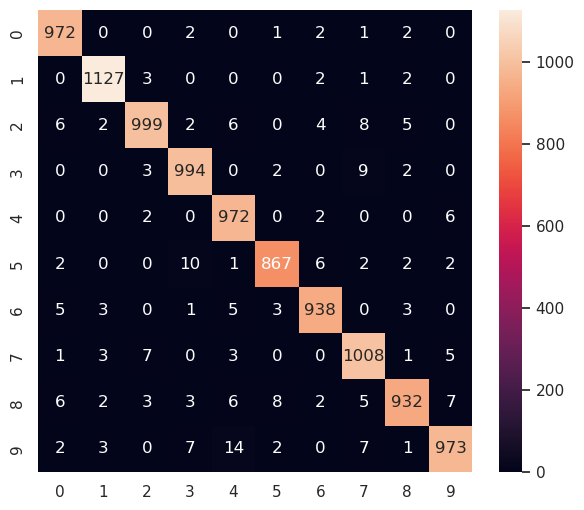

In [24]:
score_mpl = model.evaluate(X_test_flatten, Y_test, verbose=0)
predict_mpl = model.predict(X_test_flatten)
print('Test loss:', score_mpl[0])
print('Test accuracy:', score_mpl[1])
print("Time Running: %.2f seconds" %t_train_mpl )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_mpl.argmax(1))), annot=True, fmt="d")


**Question** What can you say about these results?

**Exercise** Normalize the data in order to have values between 0 and 1 and run again the learning. What can you say about these results?

## Convolutional Layers

In this part we will use convolution layers to build a convolutional classifier.


**Data**

The convolution architecture takes as input images and not 1D vectors. However, some data formating are still required.

A third dimension is required : the `channels` dimension which will allow to describe each pixel. In our case this dimension's size is only 1 because the images are only defined with grey scale. However for colour images, each pixel is coded with several values (Images are generally encoded with 3 values (RGB channels)). 

Hence, we need to reshape the images from a 28x28 dimension to a 28X28X1 dimension

In [25]:
X_train_conv = np.expand_dims(X_train,axis=-1)
X_test_conv = np.expand_dims(X_test,axis=-1)
X_train_conv.shape

(60000, 28, 28, 1)

### Edge detection

We will first check the transformation applied by a convolution layer.

In the following code, we define a convolutional network with  only one filter for which we manually define the weights.

In [37]:
conv_filter = np.array([
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
        [0.2, -0.2, 0],
    ]) #filtre vertical

#conv_filter = np.transpose(conv_filter) #horizontal

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info=None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_edge = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1))   
]) #une "couche" de filtres

 **Q** Note that in  `my_init_filter` two dimensions have been added to the conv filter. What do these dimensions represent?
 
conv_filter.reshape(xf, yf, 1, 1) = 1 canal + 1 filtre
 
The following code allows to display the image, the filter and the convoluted image.

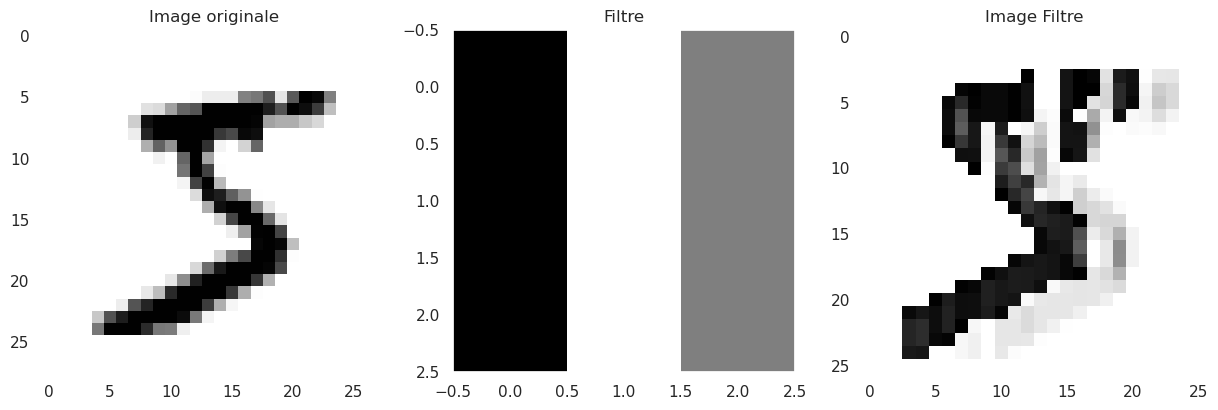

In [38]:
x = X_train_conv[0]
img_in = np.expand_dims(x, 0)
img_out = conv_edge.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0], cmap="binary")
ax0.set_title("Image originale")
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8), cmap="binary")
ax1.set_title("Filtre")
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8), cmap="binary")
ax2.set_title("Image Filtre")
ax2.grid(False)


**Q** What do you see? Are the output image coherent according to the designed filter ?

**Exercise** Change the code in order to test different filters (to detect horizontal edges, etc...)

### Strides and Padding

We will now study the effect on `strides` and `padding` arguments on the image.


In [51]:
conv_filter = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [0, 0, 0],
    ])

def my_init_filter(shape, conv_filter = conv_filter, dtype=None, partition_info = None):
    xf,yf = conv_filter.shape
    array = conv_filter.reshape(xf, yf, 1, 1)
    return array
my_init_filter(0).shape

conv_sp = km.Sequential([
    kl.Conv2D(kernel_size=(3,3), filters=1, kernel_initializer=my_init_filter, input_shape=(28, 28, 1),
           strides=2, padding="SAME") ])

conv_sp.add(kl.MaxPooling2D(pool_size = 2, strides = 1)) #pool_size=dim pour le max

**Q** What is the effect of the convolutional filter defined here ? 

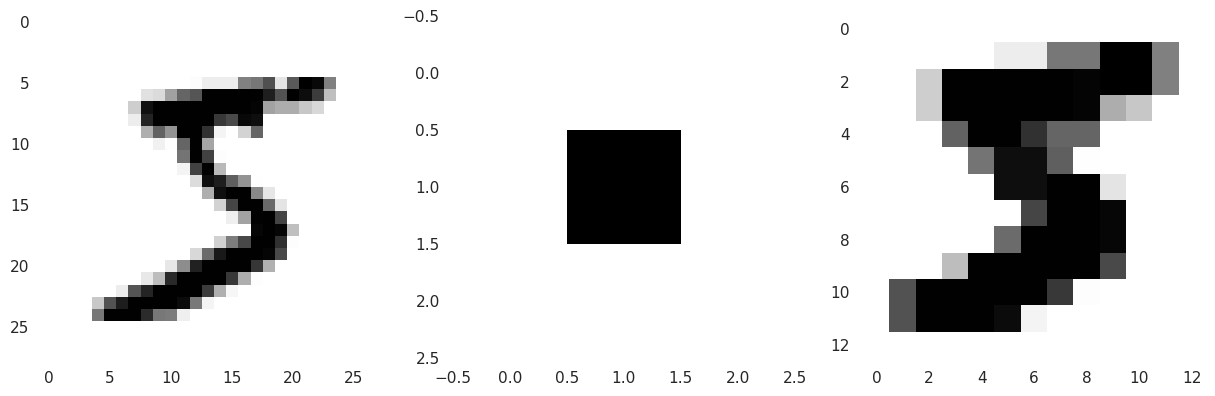

In [52]:
img_in = np.expand_dims(x, 0)
img_out = conv_sp.predict(img_in)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))
ax0.imshow(img_in[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax0.grid(False)

norm_conv_filter = (conv_filter-conv_filter.min())/conv_filter.max()
ax1.imshow(norm_conv_filter.astype(np.uint8),
           cmap="binary");
ax1.grid(False)

ax2.imshow(img_out[0,:,:,0].astype(np.uint8),
           cmap="binary");
ax2.grid(False)

**Exercise** Check the dimension of the output images. Are they coherent? <br>
**Exercise** Change both *strides* and *padding* arguments and understand the effect of these changes.

dimension divisée par 2 (stride=2) 

### Max Pooling

**Exercice** Write a similar code than above to check and understand the behaviour of the `max pooling` layer.

In [ ]:
# %load solutions/max_pooling.py

**Questions** What are the dimension of the output image? Is this normal?

## *Convolutional Network (ConvNet)*

We will now build convolutional networks and see the performances on this kind of model on  image classification problems.

### LeNet5

We first test the  LeNet5 model, proposed by LeCun et al.

In [53]:
LeNet5model = km.Sequential()
LeNet5model.add(kl.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation = 'tanh',
input_shape = (28,28,1)))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Conv2D(filters = 16, kernel_size = 5,strides = 1, activation = 'tanh'))
LeNet5model.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
LeNet5model.add(kl.Flatten())
LeNet5model.add(kl.Dense(units = 120, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 84, activation = 'tanh'))
LeNet5model.add(kl.Dense(units = 10, activation = 'softmax'))

LeNet5model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_10 (Dense)             (None, 84)              

**Exercise** Retrieve 'manually' the number of parameters of this model.

f taille de filtre
nb de parametres = ((f * f * nb de channels) + 1) * nb de filtres

conv1 = ((5 * 5 * 1) + 1) * 6

conv2 = ((5 * 5 * 6) + 1) * 16

dense1 = 256 * 120 + 120

dense2 = 120 * 84 + 84

dense3 = 84 * 10 + 10


**Question** What can you say about the total number of parameters compared with the MLP model defined before? Which layer has the highest number of parameters?

In [54]:
# Apprentissage
batch_size=128
epochs=30
LeNet5model.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adadelta(),
              metrics=['accuracy'])
ts=time.time()
LeNet5model.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Epoch 1/30
469/469 [==============================] - 43s 92ms/step - loss: 2.3694 - accuracy: 0.1285 - val_loss: 2.2855 - val_accuracy: 0.1388
Epoch 2/30
469/469 [==============================] - 42s 90ms/step - loss: 2.2538 - accuracy: 0.1543 - val_loss: 2.1877 - val_accuracy: 0.1877
Epoch 3/30
469/469 [==============================] - 46s 98ms/step - loss: 2.1639 - accuracy: 0.2183 - val_loss: 2.1069 - val_accuracy: 0.2727
Epoch 4/30
469/469 [==============================] - 44s 94ms/step - loss: 2.0880 - accuracy: 0.3038 - val_loss: 2.0335 - val_accuracy: 0.3586
Epoch 5/30
469/469 [==============================] - 45s 95ms/step - loss: 2.0168 - accuracy: 0.3758 - val_loss: 1.9627 - val_accuracy: 0.4200
Epoch 6/30
469/469 [==============================] - 44s 94ms/step - loss: 1.9464 - accuracy: 0.4365 - val_loss: 1.8925 - val_accuracy: 0.4755
Epoch 7/30
469/469 [==============================] - 43s 91ms/step - loss: 1.8819 - accuracy: 0.4825 - val_loss: 1.8221 - val_accuracy:

**Q** Why is the training time longer?

#### Results

Test loss: 0.751818835735321
Test accuracy: 0.8320000171661377
Time Running: 1325.39 seconds


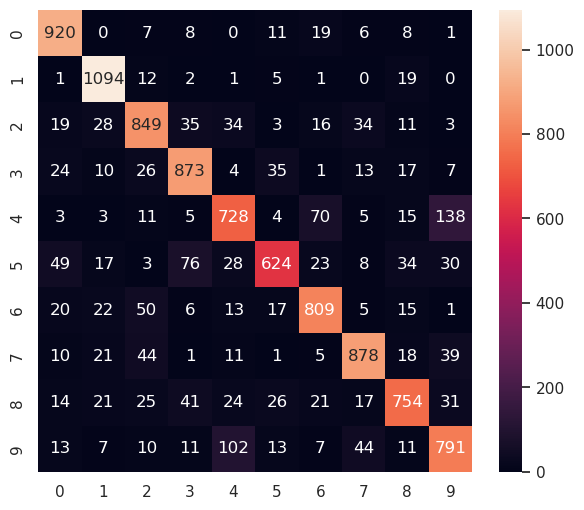

In [55]:
score_conv = LeNet5model.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = LeNet5model.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")


### A more complex architecture

#### Network

We will now design a more complex architecture to try to improve the results of the classification :

* A Conv2D layer with 32-3X3 filters and the `Relu` activation function.
* A Conv2D layer with 64-3X3 filters and the `Relu` activation function.
* A MaxPooling layer with a 2X2 window.
* A Dropout layer with a 25% drop rate.
* A flatten layer.
* A Dense layer with 128 neurons  and the `Relu` activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 10 neurons  and the `softmax` activation function.


**Exercise** Define this model and train it.

In [ ]:
# %load solutions/mnist_conv_architecture.py

In [64]:
MCAmodel = km.Sequential()
MCAmodel.add(kl.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu',
input_shape = (28,28,1)))
MCAmodel.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
MCAmodel.add(kl.Conv2D(filters = 64, kernel_size = 5,strides = 1, activation = 'relu'))
MCAmodel.add(kl.MaxPooling2D(pool_size = 2, strides = 2))
MCAmodel.add(kl.Dropout(0.25))
MCAmodel.add(kl.Flatten())
MCAmodel.add(kl.Dense(units = 128, activation = 'relu'))
MCAmodel.add(kl.Dropout(0.5))
MCAmodel.add(kl.Dense(units = 10, activation = 'softmax'))
MCAmodel.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)             

In [66]:
# Apprentissage
batch_size=128
epochs=30
MCAmodel.compile(loss="sparse_categorical_crossentropy",
              optimizer=ko.Adam(),
              metrics=['accuracy'])
ts=time.time()
MCAmodel.fit(X_train_conv, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_conv, Y_test))
te=time.time()
t_train_conv = te-ts

Epoch 1/30
469/469 [==============================] - 31s 65ms/step - loss: 2.1896 - accuracy: 0.6929 - val_loss: 0.0723 - val_accuracy: 0.9781
Epoch 2/30
469/469 [==============================] - 32s 69ms/step - loss: 0.1689 - accuracy: 0.9520 - val_loss: 0.0571 - val_accuracy: 0.9837
Epoch 3/30
156/469 [========>.....................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9636

KeyboardInterrupt: 

Test loss: 0.04406784847378731
Test accuracy: 0.9860000014305115
Time Running: 1325.39 seconds


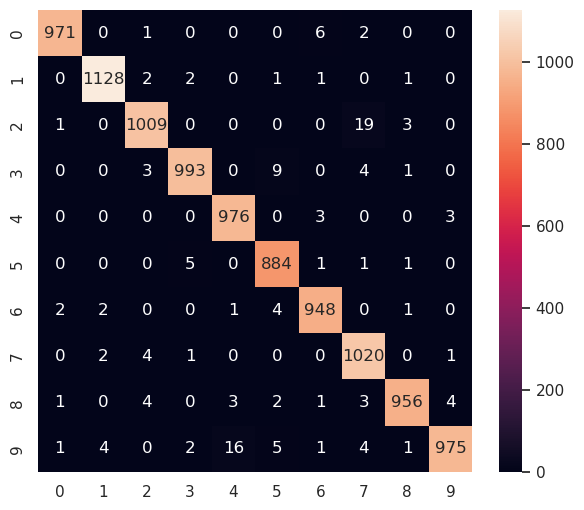

In [67]:
score_conv = MCAmodel.evaluate(X_test_conv, Y_test, verbose=0)
predict_conv = MCAmodel.predict(X_test_conv)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])
print("Time Running: %.2f seconds" %t_train_conv )

fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
ax = sb.heatmap(pd.DataFrame(confusion_matrix(Y_test, predict_conv.argmax(1))), annot=True, fmt="d")

**Q** Comment the results.

**Q** How to improve them?